In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary librarie
import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
geo_model = gp.create_model('Tutorial_ch1-1_Basics')

Advantage of sections: model resolution can be very low

In [3]:
# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0,2000.,0,2000.,0,2000.],[5,5,5], 
      path_o = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_points.csv", default_values=True); 

In [4]:
gp.map_series_to_surfaces(geo_model,
                            {"Fault_Series":'Main_Fault', 
                             "Strat_Series": ('Sandstone_2','Siltstone',
                                              'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True)

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#443988,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Strat_Series,5,True,#ff3f20,6


### Add sections

In [5]:
sdict = {'section1':([0,0],[2000,2000],[200,200]),
         'section2':([800,0],[800,2000],[150,100]),
         'section3':([0,200],[1500,500],[200,150])} #p1,p2,resolution

In [6]:
geo_model.grid.set_section_grid(sdict)

,start,stop,resolution
section1,"[0, 0]","[2000, 2000]","[200, 200]"
section2,"[800, 0]","[800, 2000]","[150, 100]"
section3,"[0, 200]","[1500, 500]","[200, 150]"


In [7]:
from gempy.plot import vis2d_sections

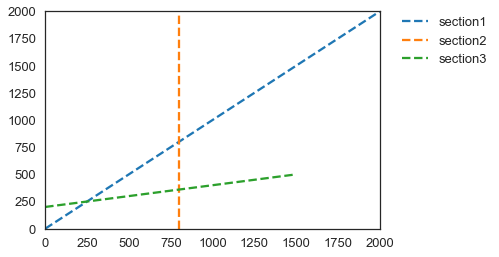

In [8]:
plot= vis2d_sections.PlotSolution(geo_model)
plot.plot_section_traces()

In [9]:
geo_model.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [10]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


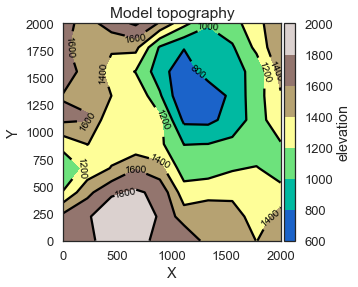

In [85]:
geo_model.set_topography(fd=1.9,d_z=np.array([600,2000]),resolution=np.array([10,10]))

In [86]:
sol = gp.compute_model(geo_model, compute_mesh=False)

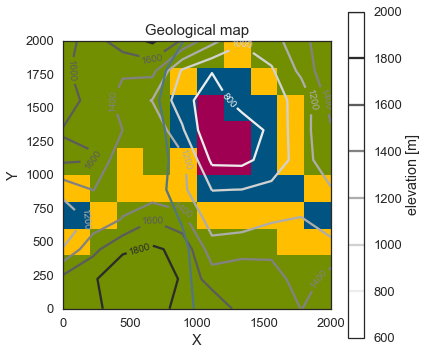

In [87]:
plot.plot_map(geo_model.solutions)

(199,) (198,)


AssertionError: 

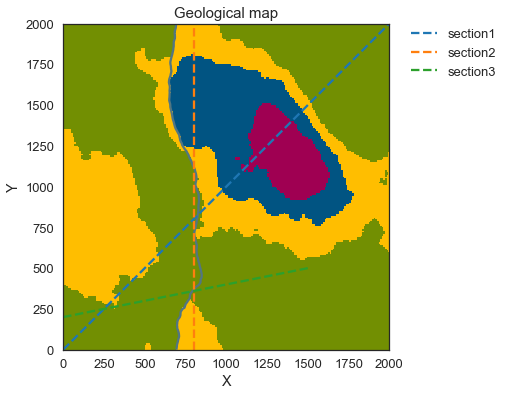

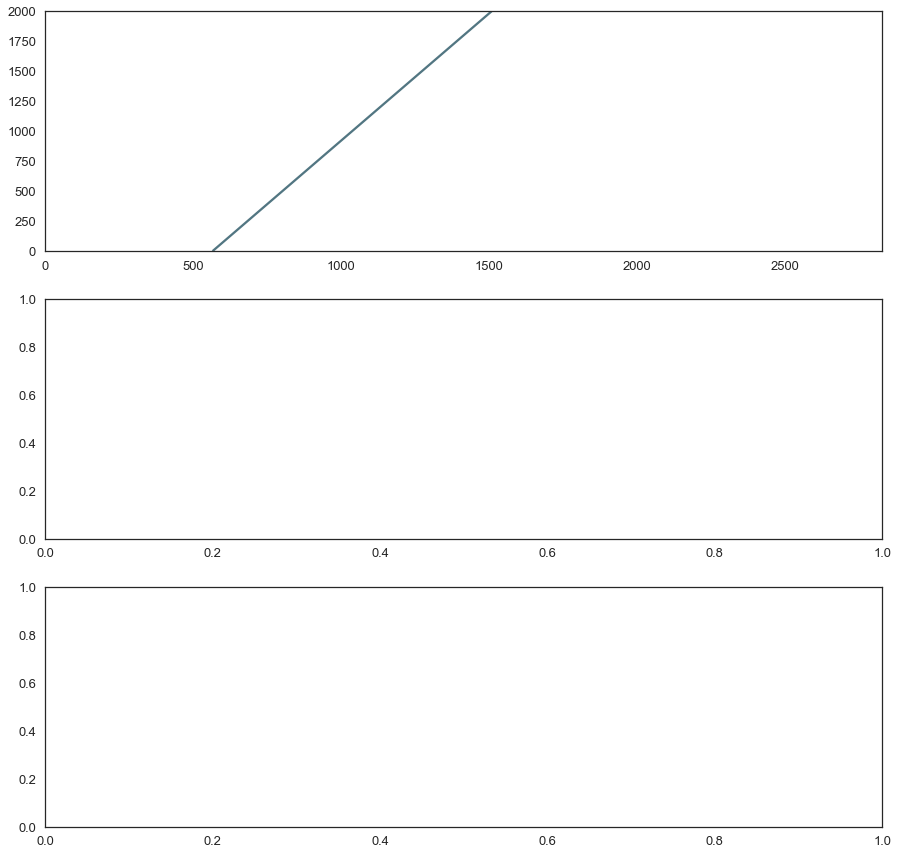

In [14]:
plot= vis2d_sections.PlotSolution(geo_model)
plot.plot_sections(figsize=(15,15))

In [79]:
def slice_topo_diagonal(self, j):
    startend = list(self.model.grid.sections.section_dict.values())[j]
    points = [(startend[0]), (startend[1])]
    ### I have checked, this is the most complicated way to do it.
    # calculate line equation
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords, rcond=None)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=int(c)))
    idx_start_x = (np.abs(self.model.grid.topography.values_3D[:, :, 0][0, :] - points[0][0])).argmin()
    idx_end_x = (np.abs(self.model.grid.topography.values_3D[:, :, 0][0, :] - points[1][0])).argmin()
    xvals = self.model.grid.topography.values_3D[:, :, 0][0, :][idx_start_x:idx_end_x]
    yvals = (m * xvals[[0, -1]] + c).astype(int)
    idx_start_y = (np.abs(self.model.grid.topography.values_3D[:, :, 1][:, 0] - yvals[0])).argmin()
    idx_end_y = (np.abs(self.model.grid.topography.values_3D[:, :, 1][:, 0] - yvals[1])).argmin()
    box = self.model.grid.topography.values_3D[idx_start_x:idx_end_x, idx_start_y:idx_end_y][:, :, 2]
    print(box.shape)
    print(xvals.shape)
    return box

In [69]:
    #print(box.T.shape)
    print(np.diag(np.flipud(box).shape))
    zvals = np.diag(np.flipud(box))  # flip it to get the right diagonal
    print(xvals.shape, zvals.shape)
    if xvals.shape != zvals.shape:
        raise AssertionError
    return np.vstack([xvals, zvals]).T

NameError: name 'box' is not defined

In [65]:
a = np.array([0,1,2,3,4,5,6,7]).reshape(4,2)

In [68]:
a

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [67]:
np.diag(a)

array([0, 3])

In [92]:
box=slice_topo_diagonal(plot, 2)

(7, 1)
(7,)


In [94]:
for i in range(box.shape[0]):
    print(box[i])

[1728.77798032]
[1660.99194131]
[1212.8970946]
[1029.20700809]
[1280.92787914]
[1634.72752071]
[1589.65126681]


In [83]:
z=[]
for i in range(box.shape[0]):
    print(i)
    #z.append(box[])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


5184